In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import os, glob
import pandas as pd

from datetime import datetime

import importlib

from tqdm import tqdm

In [2]:
satds = xr.open_mfdataset('/petastore/phil/Prasoon_satellite_project/SAMI_REGRID-at-sat_16.nc').load()

In [ ]:
#!!!!! SOMEONE (Prasoon) needs to make this file. Use the default regridding settings to interpolate the SAMI outputs to a geographic grid.


samids = xr.open_mfdataset('/petastore/phil/Prasoon_satellite_project/more_runs/20130317/') # PATH TO SAMI REGRID (NORMAL RUN)

In [5]:
satlocdf = pd.read_csv('/petastore/phil/Prasoon_satellite_project/satfiles/20130317/DMSP_all-with_datetime.csv')

f16 = satlocdf.where(satlocdf.sat == 16.0).dropna().reset_index(drop=True)

In [6]:
newtimes = satds.time.values + pd.Timedelta('731 days') # 365 days * 2 years + 1 day for leap year in 2012

In [7]:
satds['time'] = newtimes

In [8]:
satds

<xarray.Dataset>
Dimensions:  (time: 597, lat: 4320, lon: 4320, alt: 1)
Coordinates:
  * time     (time) datetime64[ns] 2013-03-16 ... 2013-03-18T01:39:54
  * lat      (lat) float64 2.8 6.3 9.8 13.3 16.8 ... 56.7 53.3 49.9 46.5 43.0
  * lon      (lon) float64 261.2 260.5 259.7 258.9 258.0 ... 94.3 92.7 91.2 89.9
  * alt      (alt) int64 840
Data variables:
    edens    (time, lat, lon, alt) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

In [59]:
f16

,glat,glon,time,sat,dayofyear,dtime,edens
0,2.8,261.2,0.0,16.0,75.0,2013-03-16 00:00:00,0.0
1,6.3,260.5,60.0,16.0,75.0,2013-03-16 00:01:00,4807.165583010137
2,9.8,259.7,120.0,16.0,75.0,2013-03-16 00:02:00,9638.638426857176
3,13.3,258.9,180.0,16.0,75.0,2013-03-16 00:03:00,14369.45259595565
4,16.8,258.0,240.0,16.0,75.0,2013-03-16 00:04:00,19460.296604329455
...,...,...,...,...,...,...,...
4315,56.7,96.1,86100.0,16.0,77.0,2013-03-18 23:55:00,nan
4316,53.3,94.3,86160.0,16.0,77.0,2013-03-18 23:56:00,nan
4317,49.9,92.7,86220.0,16.0,77.0,2013-03-18 23:57:00,nan
4318,46.5,91.2,86280.0,16.0,77.0,2013-03-18 23:58:00,nan


In [60]:
sattimes = pd.to_datetime(f16.dtime).to_numpy()

In [61]:
sattimes[0], sattimes[len(sattimes)-1], sattimes[1] - sattimes[0], satds.time[3].values

(numpy.datetime64('2013-03-16T00:00:00.000000000'),
 numpy.datetime64('2013-03-18T23:59:00.000000000'),
 numpy.timedelta64(60000000000,'ns'),
 numpy.datetime64('2013-03-16T00:14:56.004000000'))

In [62]:
type(sattimes[0]), type(satds.isel(time=0).time.values)

(numpy.datetime64, numpy.datetime64)

In [63]:
interpolated_edens = []
for ntime, dtime in enumerate(tqdm(sattimes)):
    interpolated_edens.append(
        satds.isel(lat=ntime,lon=ntime, alt=0).edens.interp(time=dtime).values)
    # All the values here are nan and I don't know why...

100%|███████████████████████████████████████████████████████████████████| 4320/4320 [00:17<00:00, 249.99it/s]


In [64]:
f16['edens'] = interpolated_edens

In [65]:
np.sum(f16.edens > 3) / len(f16)

0.6895833333333333

In [66]:
# Only ~70% valid points... why? not sure!
# That is a job for prasoon to figure out, lol

In [67]:
f16

,glat,glon,time,sat,dayofyear,dtime,edens
0,2.8,261.2,0.0,16.0,75.0,2013-03-16 00:00:00,0.0
1,6.3,260.5,60.0,16.0,75.0,2013-03-16 00:01:00,4807.165583010137
2,9.8,259.7,120.0,16.0,75.0,2013-03-16 00:02:00,9638.638426857176
3,13.3,258.9,180.0,16.0,75.0,2013-03-16 00:03:00,14369.45259595565
4,16.8,258.0,240.0,16.0,75.0,2013-03-16 00:04:00,19460.296604329455
...,...,...,...,...,...,...,...
4315,56.7,96.1,86100.0,16.0,77.0,2013-03-18 23:55:00,nan
4316,53.3,94.3,86160.0,16.0,77.0,2013-03-18 23:56:00,nan
4317,49.9,92.7,86220.0,16.0,77.0,2013-03-18 23:57:00,nan
4318,46.5,91.2,86280.0,16.0,77.0,2013-03-18 23:58:00,nan


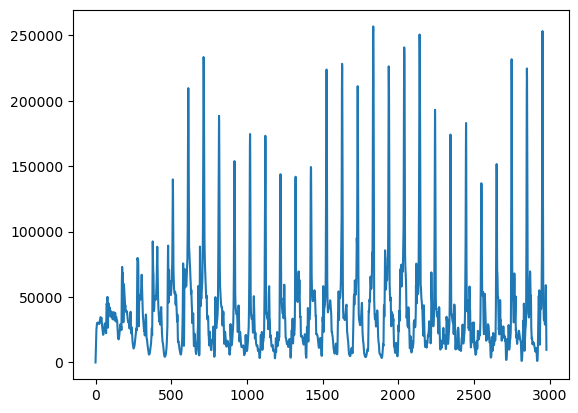

In [23]:
plt.plot(f16.edens)

In [ ]:
lochere = 50


# one satellite location throughout time...
satds.isel(lat=lochere,lon=lochere, alt=0).edens.plot()

plt.show()

# Plot that longitude, what do TIDs look like?

samids.sel(alt=840, lon=satds.isel(lon=50).lon.values).plot(x='time')
plt.title('RAW')


plt.show()


# Now the filtered values...
# # Obviously change {} and everything inside
# You can use custom bandpass filtering routines if you want, but some have been made already...
filters.{"SEL A FILTER"}(samids.sel(alt=840, lon=satds.isel(lon=50).lon.values).plot(x='time'))
plt.title('FILTERED')



In [26]:
# Find a satellite pass where there are non 0's or nans...

In [27]:
from scipy.signal import find_peaks

In [120]:
maxmin_glons, _ = find_peaks(np.abs(f16.glat))

In [154]:
valid_passes = []

pass_start_end_time = []

for i in range(len(maxmin_glons)-1):
    # When interpolations are fixed (and there are no more nans) these lines can be uncommented:
    
    # if np.sum(f16['edens'][maxmin_glons[i]: maxmin_glons[i+1]].isna()) !=0:
        # if np.sum(f16['edens'][maxmin_glons[i]: maxmin_glons[i+1]] == 0) !=0:
            valid_passes.append([maxmin_glons[i], maxmin_glons[i+1]])
            pass_start_end_time.append([f16.dtime[maxmin_glons[i]], f16.dtime[maxmin_glons[i+1]]])

In [155]:
# find satellite passes that are after storm onset
in_storm = [pd.Timestamp(t) > pd.Timestamp('2013-3-17 6:00') for t in pass_start_time] # array of bools
stormtime_pass_idxs = []
times_of_passes = []

for t in range(len(in_storm)):
    if in_storm[t]:
        stormtime_pass_idxs.append(valid_passes[t])
        times_of_passes.append(pass_start_end_time[t])

In [156]:
np.sum(in_storm), len(valid_passes), len(stormtime_pass_idxs)

(49, 84, 49)

In [157]:
numpass = 5 # pick a pass

In [158]:
selected_pass = f16.iloc[stormtime_pass_idxs[numpass][0]:stormtime_pass_idxs[numpass][1]]


In [159]:
selected_pass.head()

,glat,glon,time,sat,dayofyear,dtime,edens
2063,81.3,23.6,37380.0,16.0,76.0,2013-03-17 10:23:00,27612.48507828931
2064,81.1,0.2,37440.0,16.0,76.0,2013-03-17 10:24:00,27558.521509473296
2065,79.6,340.7,37500.0,16.0,76.0,2013-03-17 10:25:00,26731.180903385637
2066,77.3,327.1,37560.0,16.0,76.0,2013-03-17 10:26:00,26892.785159020077
2067,74.5,317.9,37620.0,16.0,76.0,2013-03-17 10:27:00,42166.615347114974


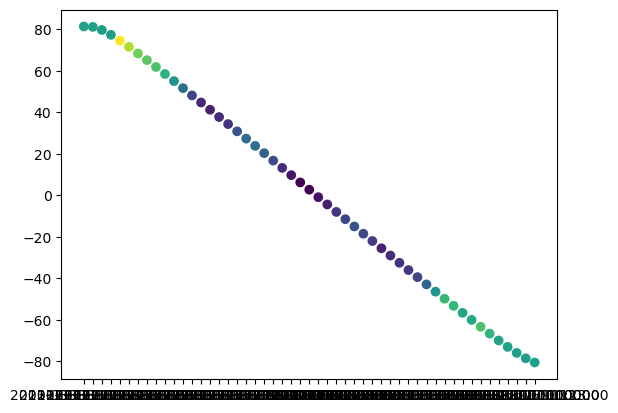

In [160]:
plt.scatter(selected_pass['dtime'], selected_pass['glat'], c=selected_pass['edens'])

In [ ]:
samids.sel(time=slice(times_of_passes[numpass][0], times_of_passes[numpass][1]), lon=np.median(selected_pass.glon), method='nearest').edens.plot(x='time', y='lat')

In [ ]:
samids.sel(time=slice(times_of_passes[numpass][0], times_of_passes[numpass][1]), lon=np.median(selected_pass.glon), method='nearest').edens.plot(x='time', y='lat')
plt.scatter(selected_pass['dtime'], selected_pass['glat'], c=selected_pass['edens'])

In [ ]:
# Then do the same with background removed, figure out how to remove background from the satellite pass....
# Someone presented this at a conference and did a bandpass filter with limits at 300 & 600 seconds.

# Since we have the satellite uinterpolated at every location and at every time we can verify background removal with that.
